<div style="display: flex; background-color:rgb(214, 234, 248 );" >
<h1 style="text-align: center;margin: auto; padding: 40px; "> Implémentez un modèle de scoring
    Projet 7 Notebook Analyse exploratoire </h1>
    <p >  Zeynep Erdem 
      
</p>
      
  
</div>

<div>
    <img style="float: right;margin:65px 5px 5px 30px" width="250px" src="logo.png"  height=400   />
</div>
<div style="display: flex; background-color:rgb(213, 219, 219);" >
<div>    

* Je suis Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
    
* "Prêt à dépenser", souhaite développer un outil de "scoring crédit" pour évaluer la probabilité de remboursement des crédits et classer les demandes en crédits accordés ou refusés. L'entreprise veut également répondre à la demande croissante de transparence de la part des clients. Pour ce faire, elle prévoit de créer un tableau de bord interactif permettant aux chargés de relation client d'expliquer les décisions d'octroi de crédit de manière transparente et de fournir aux clients un accès facile à leurs informations personnelles. 

* Mon objectif sera de:

    * Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique. 
    * Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
    * Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

    
* [Les données](https://www.kaggle.com/competitions/home-credit-default-risk/data) 
 nécessaires pour ce projet proviennent de la compétition Kaggle "Home Credit Default Risk", comprenant 10 fichiers avec 346 colonnes. Ces fichiers sont liés par des clés.  
</div>

</div>


<a name="top"></a>

# Sommaire :

**Partie 1**

 - <a href="#C1"> 1.1 Importation des librairies</a>
 - <a href="#C2"> 1.2 Importation des données</a>
 
**Partie 2 : Les analyses exploratoires sur le fichier "application train"**
 - <a href="#C3"> 2.1 Les analyses exploratoires sur le fichier "application train" </a>
     
**Partie 3 : Feature Engineering**
 - <a href="#C4"> 3.1 Feature Engineering</a> 
 
**Partie 4 : Jointures des fichiers après feature engineering**
 - <a href="#C5"> 4.1 Jointures des fichiers après feature engineering</a> 

# <a name="C1"> 1.1 Importation des librairies</a>
<a href="#top">sommaire</a>

In [1]:
# Importation des libraries
import sys
import functions
#from functions import *
import gc
import time
import re
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from contextlib import contextmanager
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Les versions des libraries
print("Python: ", sys.version)
print("Pandas: ", pd.__version__)
print("Numpy: ", np.__version__)
print("Seaborn: ", sns.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Missingno: ", msno.__version__)
print("Sklearn: ", sklearn.__version__)

Python:  3.9.17 (main, Jul  5 2023, 15:35:09) 
[Clang 14.0.6 ]
Pandas:  2.0.3
Numpy:  1.23.5
Seaborn:  0.12.2
Matplotlib:  3.7.2
Missingno:  0.4.2
Sklearn:  1.2.2


In [3]:
# Les options pour visualisations des dataframes
pd.set_option("display.max_columns", None)

# <a name="C2"> 1.2 Importation des données</a>
<a href="#top">sommaire</a>

[Les données](https://www.kaggle.com/competitions/home-credit-default-risk/data) 
 nécessaires pour ce projet proviennent de la compétition Kaggle "Home Credit Default Risk", comprenant 10 fichiers avec 346 colonnes. Ces fichiers sont liés par des clés.  

In [4]:
path = "/Users/zeyneperdem/Desktop/ds_prep/p7/data_p7/"

In [5]:
app_train = pd.read_csv(path + "application_train.csv")
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# <a name="C3"> 2.1 Exploration Data Analyses pour le fichier "application_train"
</a>
<a href="#top">sommaire</a>

## Exploration Data Analyses pour le fichier "application_train"

Pour simplifier le processus d'analyse, de préparation des données et le feature engineering, nous nous appuyons sur [un kernel](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script) Kaggle déjà existant.

In [6]:
# Pour avoir une idée rapide on va faire les analyses seulement sur le fichier "application train".

In [7]:
functions.info_general(app_train)

************************* * INFORMATIONS GENERALES DE NOTRE DATAFRAME * *************************
----------------------------------------------------------------------------------------------------

Il y a 307511 lignes et 122 colonnes dans notre dataframe.
----------------------------------------------------------------------------------------------------
* On obtiens l'info sur notre dataframe * 
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
----------------------------------------------------------------------------------------------------
* On obtient les informations statistiques sur notre dataframe * 
----------------------------------------------------------------------------------------------------


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,NaN,NaN,NaN,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,NaN,NaN,NaN,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,307511,3,F,202448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,307511,2,N,202924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,NaN,NaN,NaN,0.007,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,NaN,NaN,NaN,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,NaN,NaN,NaN,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,NaN,NaN,NaN,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


----------------------------------------------------------------------------------------------------
*On vérifie s'il y a des doublons dans notre dataframe* 
** Il n'y a pas de doublons **
----------------------------------------------------------------------------------------------------
** On vérifie s'il y a des valeurs nulles et on display pourcentage des valeurs nulles par colonne en descendant **
----------------------------------------------------------------------------------------------------
** On a  24.4 % de valeur nulle dans notre dataframe **


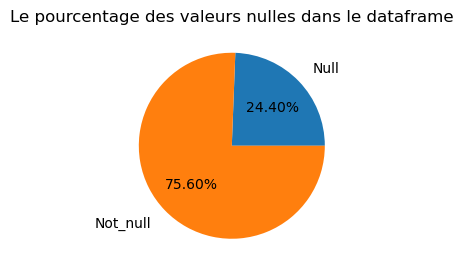

In [8]:
functions.graph_null(app_train)

In [9]:
# On vérifie s'il y a doublon pour les id
app_train.SK_ID_CURR.duplicated().sum()

0

In [10]:
# Il n'y a pas des doublons

In [11]:
df_null = functions.per_null_dataframe(app_train)
df_null

,nombre_null,pourcentage_null
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
...,...,...
NAME_HOUSING_TYPE,0,0.00
NAME_FAMILY_STATUS,0,0.00
NAME_EDUCATION_TYPE,0,0.00
NAME_INCOME_TYPE,0,0.00


In [12]:
# Les colonnes incluent plus de 30% de valeurs manquantes
df_null[df_null["pourcentage_null"] > 30]

,nombre_null,pourcentage_null
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35


In [13]:
df_null[df_null["pourcentage_null"] > 30].shape

(50, 2)

In [14]:
# Les colonnes numériques et catégoriques
# Identify numeric and categorical columns
numeric_columns = app_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = app_train.select_dtypes(include=['object']).columns

In [15]:
categorical_columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [16]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

# EDA

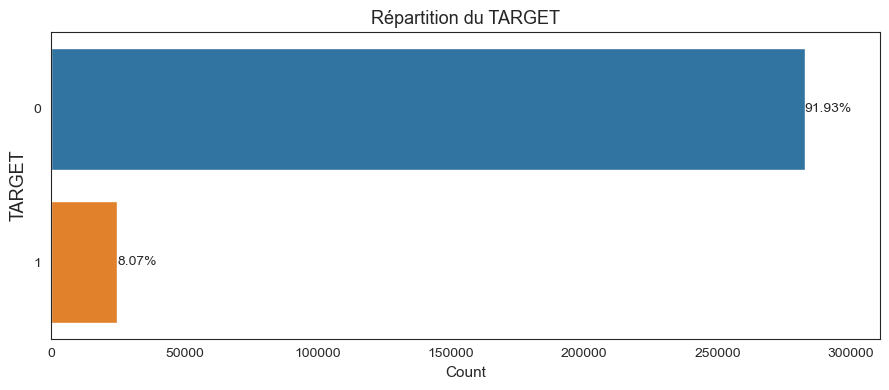

In [17]:
functions.countplot(app_train, "TARGET", figsize=(9, 4))

In [18]:
# Notre target n'est pas équilibré

On s'est inspiré de [ce kernel](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction) Kaggle déjà existant pour simplifier le processus d'analyse exploratoire.

## Outliers

In [19]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [20]:
app_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [21]:
def kdeplot_and_boxplot(df, columns, figsize=(12, 3)):
    if not isinstance(columns, list):
        columns = [columns]

    num_columns = len(columns)
    fig, axes = plt.subplots(
        num_columns, 2, figsize=(figsize[0], figsize[1] * num_columns)
    )

    for i, col in enumerate(columns):
        if num_columns == 1:  # Adjust subplots if only one column is provided
            ax_kdeplot = axes[0]
            ax_boxplot = axes[1]
        else:
            ax_kdeplot = axes[i, 0]
            ax_boxplot = axes[i, 1]

        # KDE Plot
        sns.kdeplot(data=df, x=col, ax=ax_kdeplot)
        ax_kdeplot.set_title("Kde Plot - " + col)
        ax_kdeplot.set_xlabel(col)

        # Boxplot
        sns.boxplot(data=df, x=col, ax=ax_boxplot)
        ax_boxplot.set_title("Box Plot - " + col)
        ax_boxplot.set_xlabel(col)

    plt.tight_layout()
    plt.show()


In [22]:
cols_anomalie = ['DAYS_EMPLOYED', 'DAYS_BIRTH']

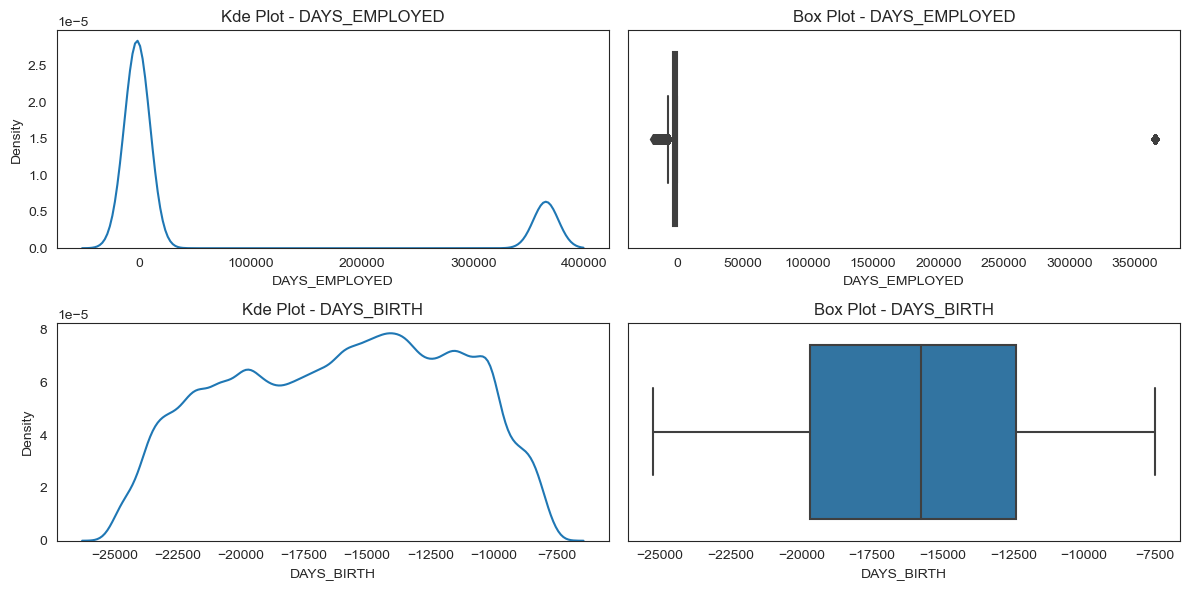

In [23]:
kdeplot_and_boxplot(app_train, cols_anomalie, figsize=(12, 3))

In [24]:
# On va faire quelque preproccessing pour ces colonnes
# Dans le notebook modélisation et va remplacer les valeurs 365243 avec nulls et on va les imputer après.
# De plus, on va convertir les valeurs négatives en valeurs positives, et les jours en années.

In [25]:
copy_app_train = app_train.copy()

In [26]:
copy_app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [27]:
copy_app_train['DAYS_BIRTH'] = copy_app_train['DAYS_BIRTH']/-365

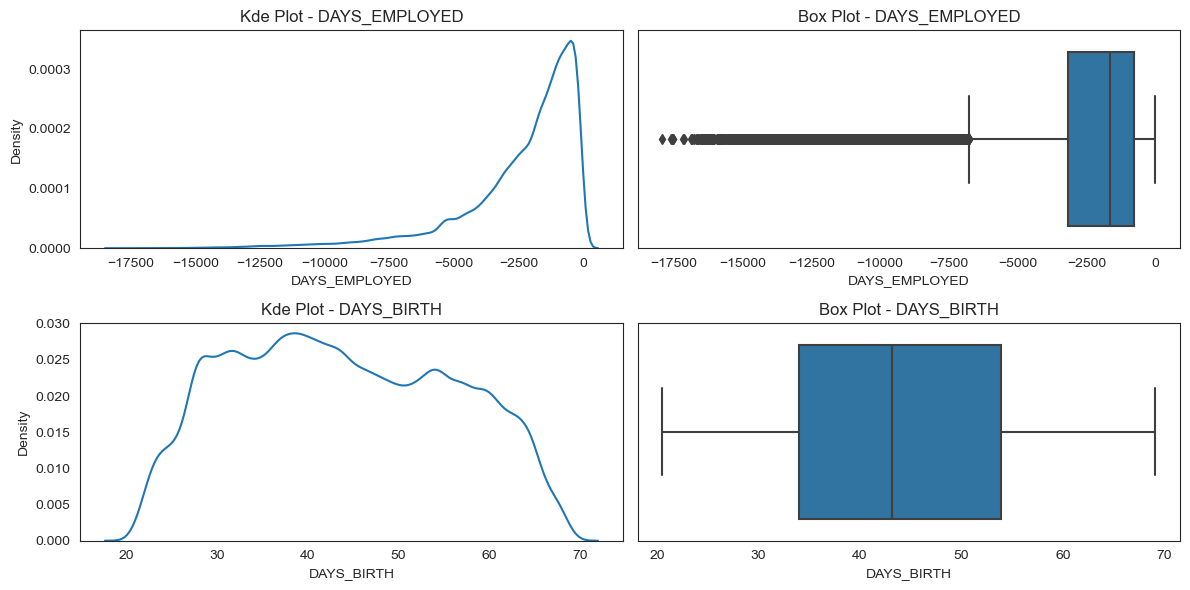

In [28]:
kdeplot_and_boxplot(copy_app_train, cols_anomalie, figsize=(12, 3))

In [29]:
def kdeplot_and_boxplot_by_target(df, target_col, feature_cols, figsize=(12, 5)):
    num_feature_cols = len(feature_cols)
    fig, axes = plt.subplots(
        num_feature_cols, 2, figsize=(figsize[0], figsize[1] * num_feature_cols)
    )

    for i, col in enumerate(feature_cols):
        if num_feature_cols == 1:  # Adjust subplots if only one feature column is provided
            ax_kdeplot = axes[0]
            ax_boxplot = axes[1]
        else:
            ax_kdeplot = axes[i, 0]
            ax_boxplot = axes[i, 1]

        # KDE Plot for clients who didn't pay the loan
        sns.kdeplot(data=df[df[target_col] == 0][col], ax=ax_kdeplot, label="Solvable", color='blue')
        ax_kdeplot.set_title("KDE Plot - " + col)
        ax_kdeplot.set_xlabel(col)

        # KDE Plot for clients who paid the loan
        
        sns.kdeplot(data=df[df[target_col] == 1][col], ax=ax_kdeplot, label="Non solvable", color='red')
        # Boxplot for both groups
        sns.boxplot(data=df, x=target_col, y=col, ax=ax_boxplot, palette={1: 'red', 0: 'blue'})
        ax_boxplot.set_title("Box Plot - " + col)
        ax_boxplot.set_xlabel(target_col)
        ax_boxplot.set_ylabel(col)
        
        # Create a separate legend for the box plot
        handles, labels = ax_boxplot.get_legend_handles_labels()
        legend_labels = ["Solvable", "Non solvable"]
    
        # Create custom artists for the legend
        custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                                    markersize=8, label=label) for color,
                         label in zip(['blue', 'red'], legend_labels)]
    
        #plt.legend(handles=custom_legend, loc='upper right')

        ax_kdeplot.legend()
        ax_boxplot.legend(handles=custom_legend, loc='lower right')
        #plt.legend(handles=custom_legend, loc='lower right')
    plt.tight_layout()
    plt.show()

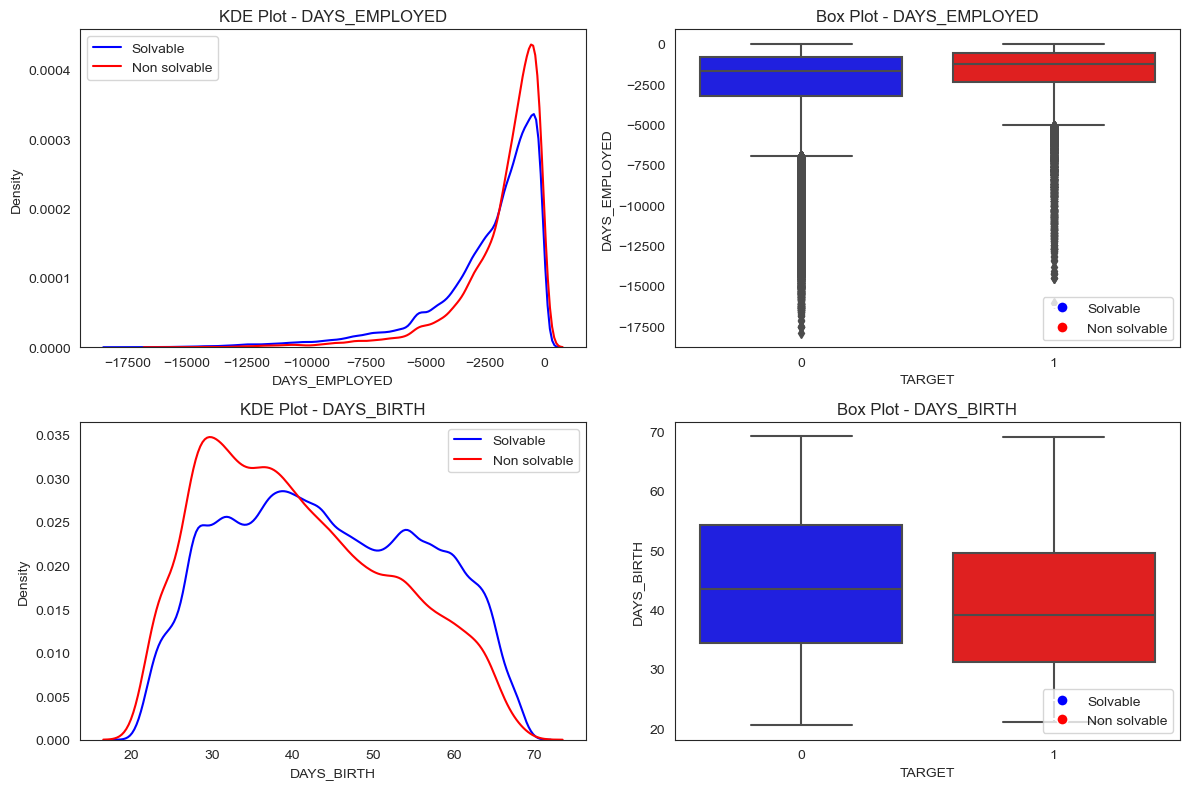

In [30]:
kdeplot_and_boxplot_by_target(copy_app_train, "TARGET", cols_anomalie, figsize=(12, 4))

In [31]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,-9461,25.920548,"(25.0, 30.0]"
1,0,-16765,45.931507,"(45.0, 50.0]"
2,0,-19046,52.180822,"(50.0, 55.0]"
3,0,-19005,52.068493,"(50.0, 55.0]"
4,0,-19932,54.608219,"(50.0, 55.0]"
5,0,-16941,46.413699,"(45.0, 50.0]"
6,0,-13778,37.747945,"(35.0, 40.0]"
7,0,-18850,51.643836,"(50.0, 55.0]"
8,0,-20099,55.065753,"(55.0, 60.0]"
9,0,-14469,39.641096,"(35.0, 40.0]"


In [32]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


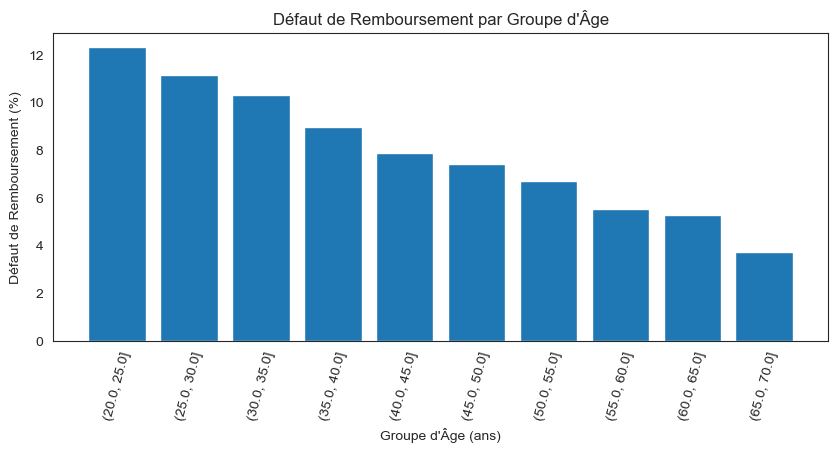

In [33]:
plt.figure(figsize = (10, 4))
# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
# Plot labeling
plt.xticks(rotation = 75); plt.xlabel("Groupe d'Âge (ans)"); plt.ylabel('Défaut de Remboursement (%)')
plt.title("Défaut de Remboursement par Groupe d'Âge");

In [34]:
# On constate que le taux de défaut de remboursement est plus élevé chez les clients de moins de 30 ans.

# Correlations

In [35]:
# Il y a les variables très corréles à notre Target?

In [36]:
# Correlations avec target
correlations = copy_app_train.select_dtypes(include=['int64', 'float64']).corr()['TARGET']

# Display correlations
print('-'*25,'10 positive corrélations','-'*25)
display(correlations.sort_values(ascending=False).head(10))
print('-'*25,'10 negative corrélations','-'*25)
display(correlations.sort_values().head(10))

------------------------- 10 positive corrélations -------------------------


TARGET                         1.000000
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64

------------------------- 10 negative corrélations -------------------------


EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_BIRTH                   -0.078239
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

In [37]:
cols_for_corr = ["TARGET", "DAYS_BIRTH", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

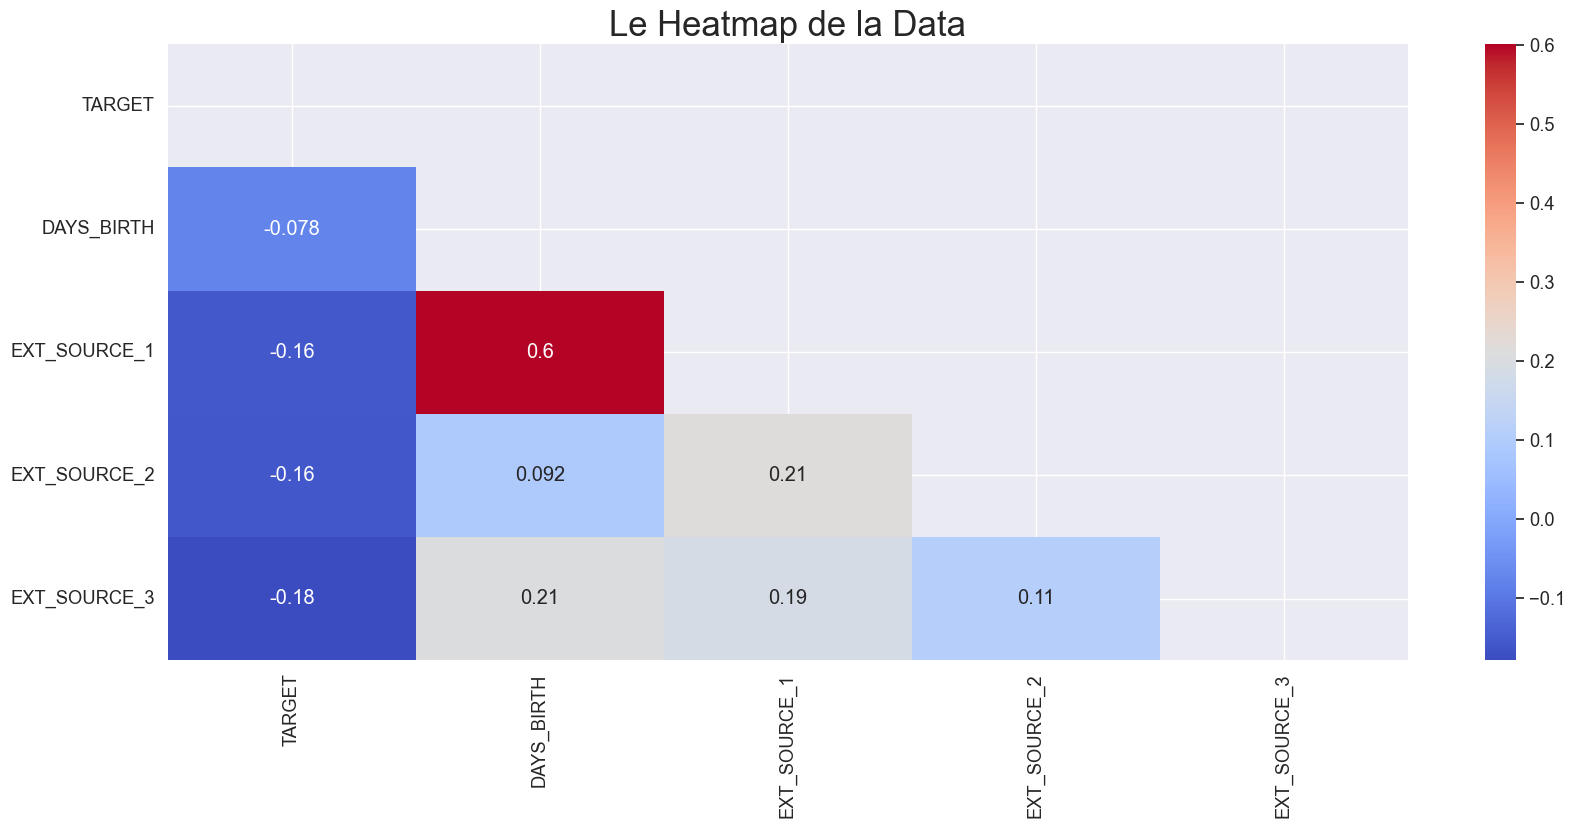

In [38]:
functions.heatmap(copy_app_train[cols_for_corr])

In [39]:
# Pour l'instant on n'a pas des variables très corrélées à target ou entre eux.
# Mais après jointures des fichiers on va éliminer les variables très corrélées dans le notebook modélisation.

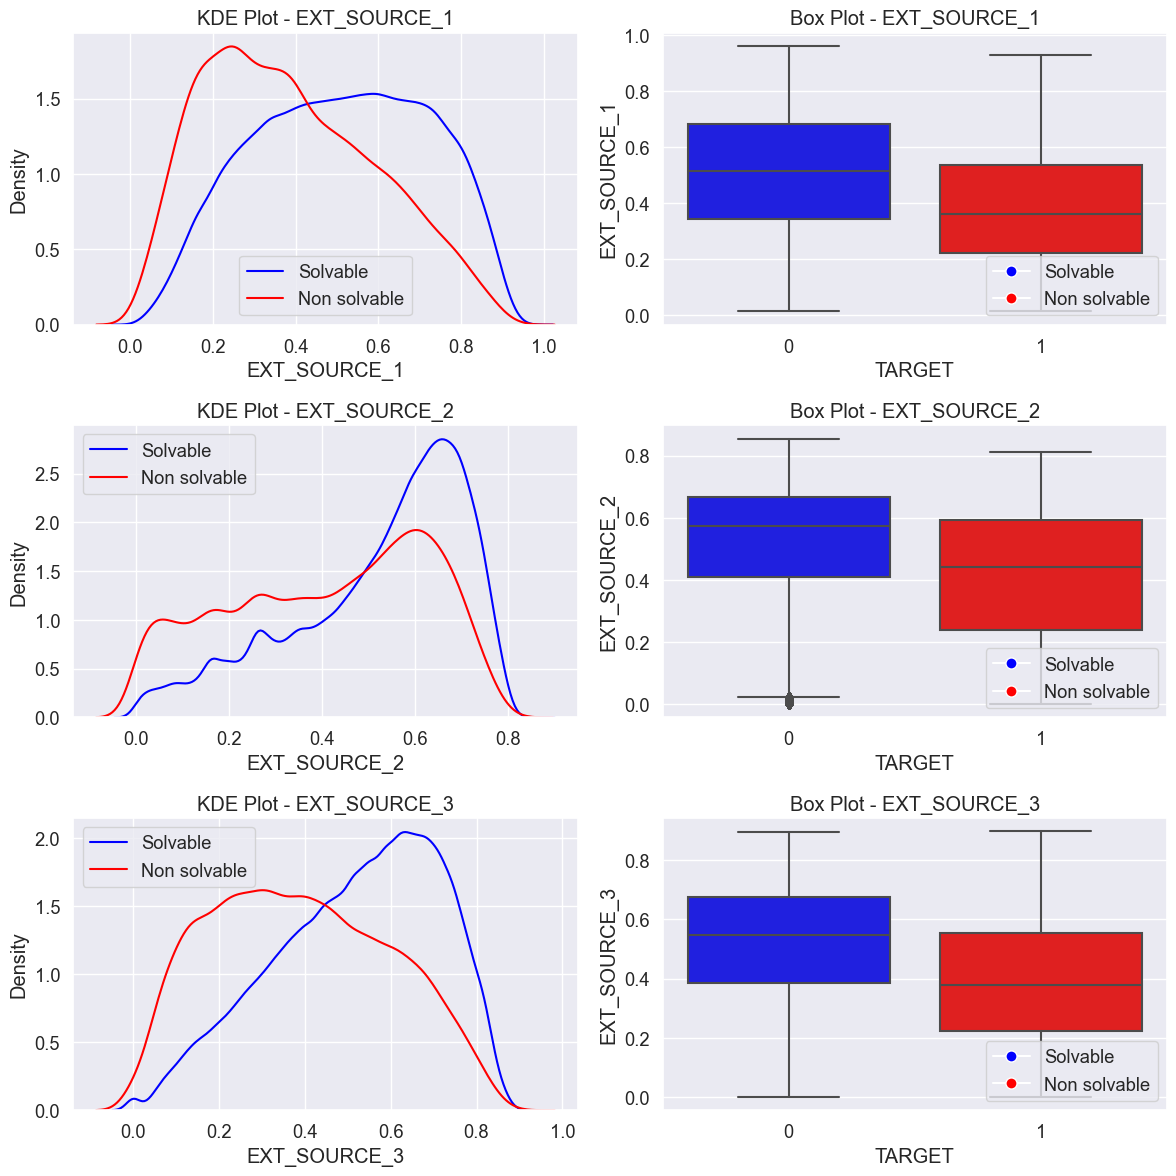

In [40]:
kdeplot_and_boxplot_by_target(copy_app_train, "TARGET", ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"], 
                                                         figsize=(12, 4))

In [41]:
# Les clients solvables ont un score EXT_SOURCE plus élevé que les non solvables.

# <a name="C4"> 3.1 Feature Engineering</a>
<a href="#top">sommaire</a>

Ici on va faire créer quelques variables mais on va faire le feature enginnering plus approfondi dans la fonction de kernel exmple

## Features liées aux connaissances du domaine
Il se peut que l'appellation "connaissances du domaine" ne soit pas tout à fait correcte, car on n'est pas un expert en crédit, 
mais nous pourrions peut-être les qualifier de "tentatives d'application de connaissances financières limitées". 
Dans cet esprit, nous pouvons créer quelques caractéristiques qui tentent de capturer 
ce que nous pensons être important pour déterminer si un client fera défaut sur un prêt.

* POURCENTAGE_CRÉDIT_REVENUS : le pourcentage du montant du crédit par rapport au revenu du client.
* POURCENTAGE_ANNUITÉ_REVENUS : le pourcentage de l'annuité du prêt par rapport au revenu du client.
* DURÉE_CRÉDIT : la durée du remboursement en mois (puisque l'annuité est le montant mensuel dû).
* POURCENTAGE_JOURS_EMPLOI : le pourcentage des jours employés par rapport à l'âge du client.

In [42]:
copy_app_train['CREDIT_INCOME_PERCENT'] = copy_app_train['AMT_CREDIT'] / copy_app_train['AMT_INCOME_TOTAL']
copy_app_train['ANNUITY_INCOME_PERCENT'] = copy_app_train['AMT_ANNUITY'] / copy_app_train['AMT_INCOME_TOTAL']
copy_app_train['CREDIT_TERM'] = copy_app_train['AMT_ANNUITY'] / copy_app_train['AMT_CREDIT']
copy_app_train['DAYS_EMPLOYED_PERCENT'] = copy_app_train['DAYS_EMPLOYED'] / copy_app_train['DAYS_BIRTH']

### Visualiser les nouvelles variables
Nous devrions explorer visuellement ces variables liées aux connaissances du domaine dans un graphique. Pour chacune d'entre elles, nous allons créer le même graphique à densité kernel (KDE) et boxplot coloré en fonction de la valeur de la TARGET.

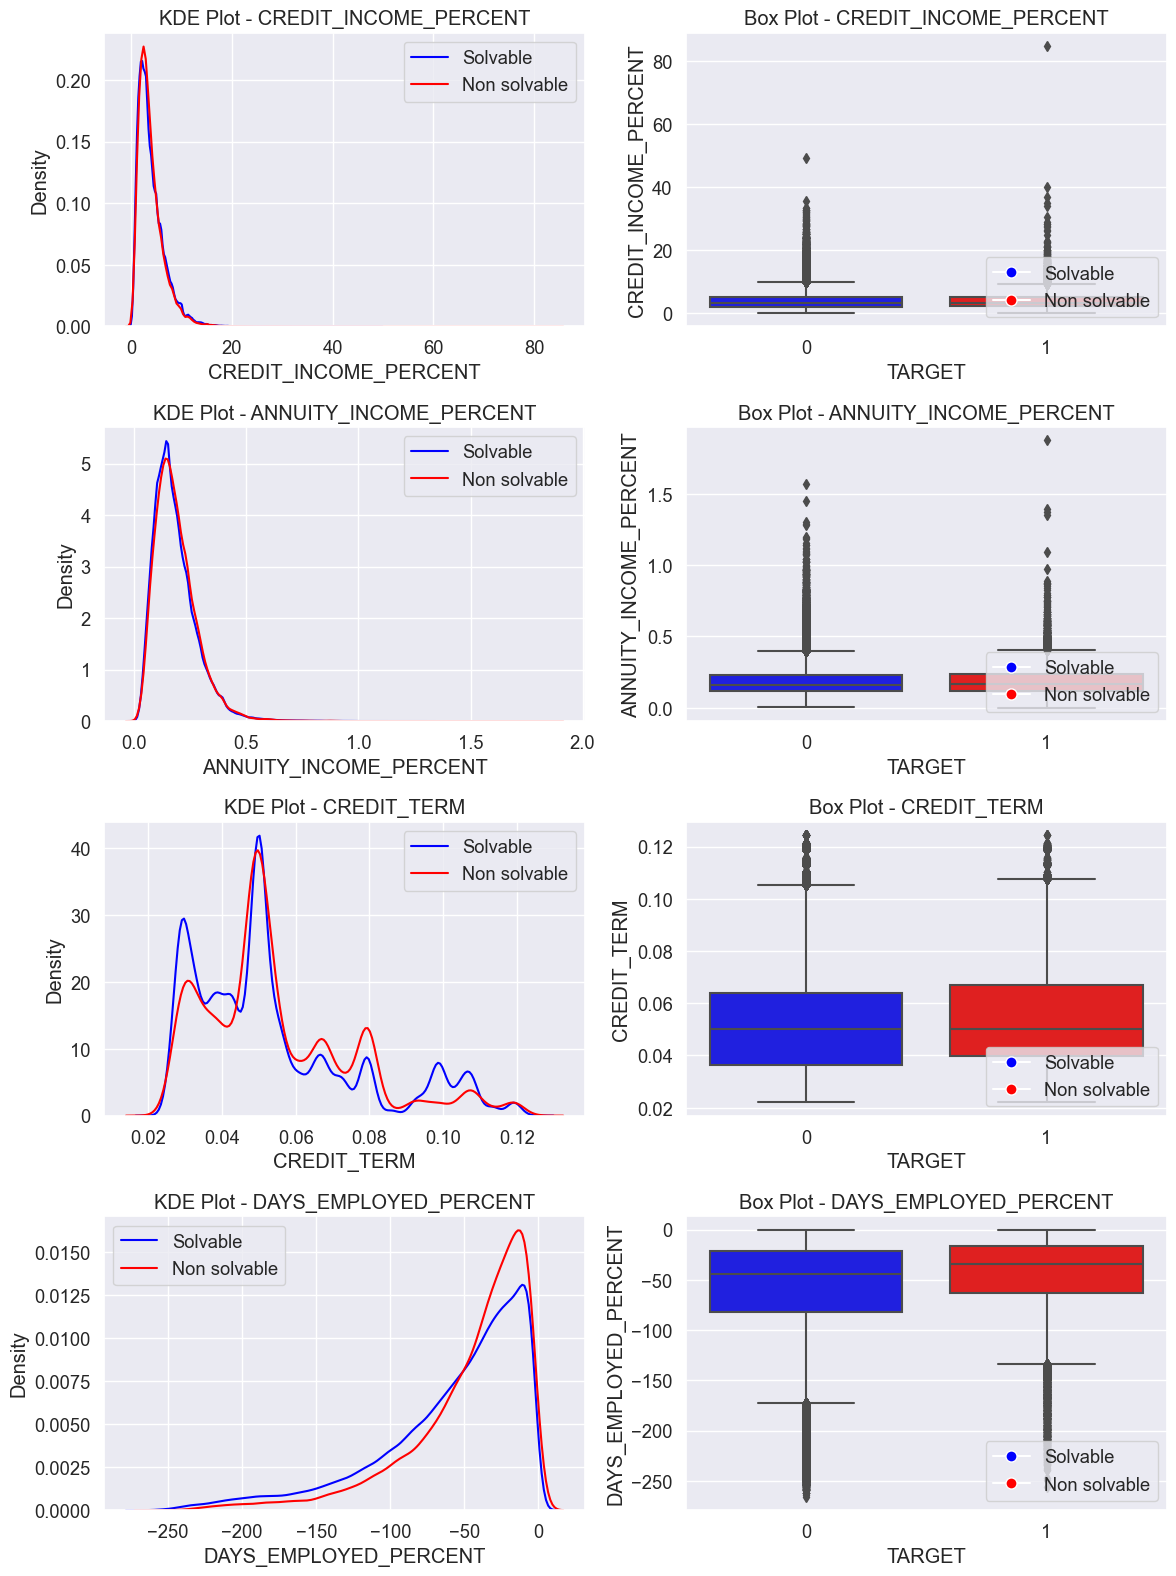

In [43]:
kdeplot_and_boxplot_by_target(copy_app_train, "TARGET", ['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT',
                                                         'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT'], 
                                                         figsize=(12, 4))

# <a name="C5"> 4.1 Jointures des fichiers après feature engineering"
</a>
<a href="#top">sommaire</a>

In [44]:
# Après ces analyses on va faire les jointures entre les fichiers.

Dans la fonction on fait ces changements:
* Traitement des outliers
    * Elimination de XNA de la colonne  CODE_GENDER
    * Remplacement des valeurs 365243, par np.nan  dans la colonne DAYS_EMPLOYED (1000 ans de travail)
* Création des nouvelles colonnes
    * Calculs arithmétiques exp: PAYMENT_RATE = AMT_ANNUITY /AMT_CREDIT
    * Aggregations ['max', 'mean', 'sum']
* Encodage
    * Label encoding pour binary colonnes
    * One hot encoding pour les autres colonnes catégorielles

In [45]:
# Load preprocessed data using 
data_all = functions.main()
data_all.head()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 11s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 10s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 4s
Installments payments df shape: (339587, 26)
Process installments payments - done in 13s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 7s


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGAN

In [46]:
data_all.shape

(356251, 797)

In [47]:
#data_all.to_csv('data_all.csv', index = False)

In [48]:
#data_all = pd.read_csv("data_all.csv")

In [49]:
data_test = data_all[data_all['TARGET'].isnull()]
data_train = data_all[data_all['TARGET'].notnull()]

In [50]:
print("Taille du jeu d'entrainement: ", data_train.shape)
print("Taille du jeu de test: ", data_test.shape)

Taille du jeu d'entrainement:  (307507, 797)
Taille du jeu de test:  (48744, 797)


In [51]:
#dataset = data_train.copy()
#dataset.to_csv('dataset.csv', index = False)
#dataset.head(3)

In [52]:
pwd

'/Users/zeyneperdem/Desktop/ds_prep/p7'

In [53]:
dataset = pd.read_csv("dataset.csv")
dataset.head(2)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGAN

In [54]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).